In [1]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Config
sns.set(color_codes=True)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
from useful_functions import *

## Score constituencies

In [3]:
ge10, ge15, ge17 = read_in_election_results() 

In [4]:
diff_17 = score_campaigns_difference(ge17, ge15)
uns_17  = score_campaigns_uns(ge17, ge15)
mrp_17  = score_campaigns_mrp(ge17)

In [5]:
# this dataframe is just for reference
scores = pd.concat( [ge17['Constituency'],diff_17['difference'],uns_17['difference'],mrp_17['difference'] ],
                    axis=1, verify_integrity=True, sort=True)
scores.columns = ['Constituency','diff','uns','mrp']
scores.sort_values('mrp',ascending=False).head(10)

,Constituency,diff,uns,mrp
E14000721,Hackney South and Shoreditch,13341.0,0.052593,0.192414
E14000581,Bootle,8640.0,-0.002234,0.155340
E14000760,Ilford South,10492.0,0.020187,0.150347
W07000070,Cynon Valley,4872.0,0.035253,0.144150
E14000801,Luton South,10144.0,0.084356,0.127369
E14000775,Knowsley,7723.0,-0.025753,0.120433
S14000024,Edinburgh South,6976.0,0.059651,0.118101
E14000732,Harrow West,8755.0,0.040875,0.113480
E14000679,East Ham,6561.0,-0.041637,0.113094
E14000687,Edmonton,5833.0,0.002643,0.112799


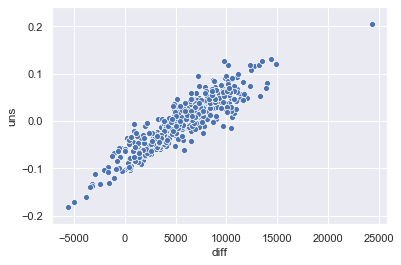

In [6]:
sns.scatterplot(scores['diff'],scores['uns'])

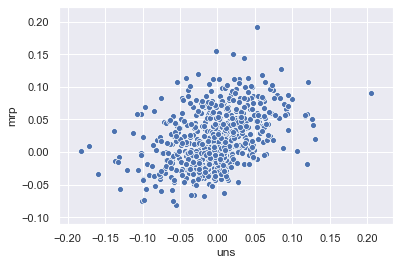

In [7]:
sns.scatterplot(scores['uns'],scores['mrp'])

In [8]:
# seats that labour won by, or were within a certain percentage of winning
marginals = calc_marginal_within(0.10,ge17)

## Select demographic data to compare constituencies

In [9]:
census = read_in_census()
print(len(census))
# only want rows we have election data for
census = census.loc[ge17.index]
print(len(census))

650
631


In [10]:
features = ['c11PopulationDensity',
                'c11HouseOwned',
                'c11CarsNone',
                'c11EthnicityWhite',
                 'c11Unemployed',
                 'c11Retired',
                 'c11FulltimeStudent',
                 'c11Age65to74',
                 'c11DeprivedNone']

In [11]:
demographic_data = census[features]
print(len(demographic_data))
demographic_data = demographic_data.dropna()
print(len(demographic_data))

631
572


In [12]:
# a list of constituencies we have complete data for
constits_id = demographic_data.index
scores = scores.loc[constits_id] # so we can compare between tables
constits_name = [name_from_onsid(i,ge17) for i in constits_id]

constits_onsid_to_index = {onsid:i for i,onsid in enumerate(constits_id)}
constits_name_to_index = {name:i for i,name in enumerate(constits_name)}

## Calculate confidence that a local campaign was succesful

All constituencies are compared with each other.

We calculate the 'distance' between each constituency base on their demographics. Similar constituencies, based on the features chosen above' will have a small distance between them.

We then calculate the relative score between each campaign.

This score is divided by the distance for each constituency. Our confidence in this constituencies campaing is the sum of this value for all other constituencies.

If constituency A scored much better than constituency B, and they are very similar in demographics, A will recieve a positive contribution and B will recieve a negative one.

In [13]:
from sklearn import preprocessing
from sklearn.metrics import pairwise_distances

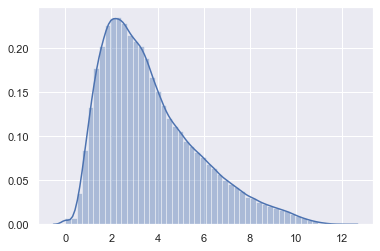

In [14]:
X_scaled = preprocessing.scale(demographic_data)
dist_matrix = pairwise_distances(X_scaled)
sns.distplot(np.ndarray.flatten(dist_matrix))

In [112]:
def distance(X, cutoff=None):
    return pairwise_distances(X)

def distance_rescale_simple(X, cutoff):
    dist_matrix = distance(X)
    mask = dist_matrix > cutoff
    dist_matrix[mask] = 0
    return dist_matrix

def distance_rescale(X, cutoff):
    dist_matrix = distance(X)
    n = len(dist_matrix)
    for i in range(n):
        for j in range(n):
            if 0 < dist_matrix[i][j] < cutoff:
                dist_matrix[i][j] = 1 / (cutoff - dist_matrix[i][j])
            else: 
                dist_matrix[i][j] = 0
    return dist_matrix

def calc_significance_matrix(demographic_data, constit_score, 
                             dist_func=distance, cutoff=None):
    constit_score = constit_score.loc[demographic_data.index]
    X_scaled      = preprocessing.scale(demographic_data)
    
    dist_matrix   = dist_func(X_scaled,cutoff)
    constit_score = preprocessing.scale(constit_score)
    score_matrix  = constit_score[:,np.newaxis] - constit_score
    significance  = np.zeros(score_matrix.shape) # need to initialise all to zero
    return np.divide(score_matrix, dist_matrix, where=dist_matrix!=0)
    
def calc_campaign_conf(demographic_data, constit_score, 
                             dist_func=distance, cutoff=None):
    significance = calc_significance_matrix(demographic_data, constit_score, dist_func, cutoff)
    return pd.Series(np.sum(significance,1),index=demographic_data.index)

In [99]:
diff = calc_campaign_conf(demographic_data, scores['diff'])
uns = calc_campaign_conf(demographic_data, scores['uns'])
mrp = calc_campaign_conf(demographic_data, scores['mrp'])

In [100]:
cutoff = 5
diff_cut = calc_campaign_conf(demographic_data, scores['diff'],distance_rescale_simple, cutoff)
uns_cut  = calc_campaign_conf(demographic_data, scores['uns'],distance_rescale_simple, cutoff)
mrp_cut  = calc_campaign_conf(demographic_data, scores['mrp'],distance_rescale_simple, cutoff)

In [101]:
cutoff = 2
diff_rescale = calc_campaign_conf(demographic_data, scores['diff'],distance_rescale, cutoff)
uns_rescale  = calc_campaign_conf(demographic_data, scores['uns'],distance_rescale, cutoff)
mrp_rescale  = calc_campaign_conf(demographic_data, scores['mrp'],distance_rescale, cutoff)

In [102]:
results = pd.DataFrame({'constituency': constits_name,
                        'diff': diff, 'uns': uns, 'mrp': mrp,
                        'diff_cut': diff_cut, 'uns_cut': uns_cut, 'mrp_cut': mrp_cut,
                        'diff_rescale': diff_rescale, 'uns_rescale': uns_rescale, 'mrp_rescale': mrp_rescale},
                       index = constits_id)
results.head(10)

,constituency,diff,uns,mrp,diff_cut,uns_cut,mrp_cut,diff_rescale,uns_rescale,mrp_rescale
ons_id,,,,,,,,,,
E14000530,Aldershot,76.598684,163.274203,48.252000,482.378598,160.355829,56.852945,1289.101779,27.486553,12.190624
E14000531,Aldridge-Brownhills,-231.928558,-132.050079,-40.878108,406.542415,-116.819784,-22.734029,877.211080,-32.004120,2.058437
E14000532,Altrincham and Sale West,100.034591,134.316126,156.341001,737.985300,132.702982,165.901881,1061.696047,56.824844,86.806173
E14000533,Amber Valley,-454.447566,-437.824784,-254.522746,115.556494,-413.062933,-229.628541,510.714880,-211.123345,-113.739813
E14000534,Arundel and South Downs,131.742643,95.796978,2.454435,1183.553061,96.191690,25.175666,1038.437517,44.417057,25.896176
E14000535,Ashfield,-391.796382,-535.182481,-87.664545,110.072496,-506.908193,-71.729267,822.613115,-212.989026,-37.904371
E14000536,Ashford,153.173727,102.515766,265.157255,644.152990,104.987309,269.834826,806.787493,53.100635,159.348348
E14000537,Ashton-under-Lyne,-109.073055,31.065113,415.559946,139.272829,35.372797,410.835699,1310.943716,14.328362,91.762178
E14000538,Aylesbury,286.217141,273.379619,197.978652,766.653712,264.590869,200.123809,1220.341870,80.199051,73.838551


In [103]:
from sklearn.metrics import r2_score


In [104]:
r2_score(
    preprocessing.scale(scores['mrp']),
    preprocessing.scale(results['diff_rescale'])
)

-0.9420012309404695

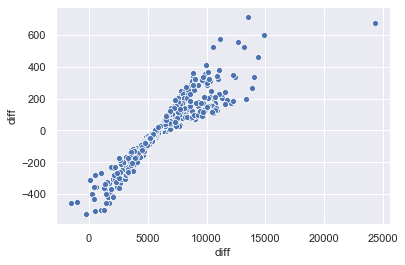

In [105]:
sns.scatterplot(x=scores['diff'],
                y=results['diff'])

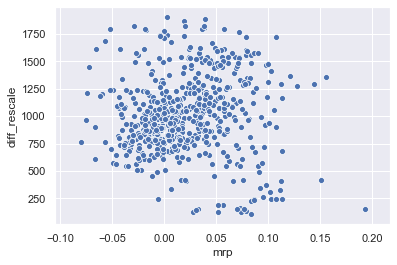

In [106]:
sns.scatterplot(x=scores['mrp'], y=results['diff_rescale'])

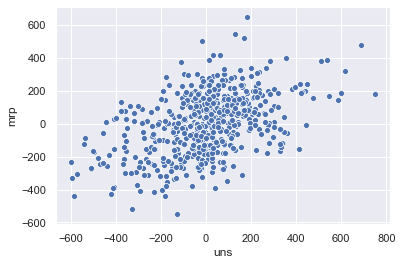

In [107]:
sns.scatterplot(x=results['uns'], y=results['mrp'])

In [108]:
results.sort_values('diff',ascending=False).head()

,constituency,diff,uns,mrp,diff_cut,uns_cut,mrp_cut,diff_rescale,uns_rescale,mrp_rescale
ons_id,,,,,,,,,,
E14001003,Truro and Falmouth,714.977288,750.131747,181.822109,1298.544951,715.924538,189.049980,1062.350750,261.291177,86.313682
E14000602,Bristol West,677.408865,475.266975,157.611114,3206.783313,133.627633,33.731383,495.130399,2.598010,0.825227
E14000755,Hove,602.069634,508.861996,379.413143,799.488461,495.458908,372.969249,1725.216436,24.876561,22.255138
E14000682,East Worthing and Shoreham,576.775204,686.856829,473.362494,1098.684420,664.828734,468.626827,977.603594,356.308089,264.710431
E14000599,Bristol East,556.311580,599.842657,185.397667,758.265616,587.551685,186.408720,1448.575493,107.555399,30.310365


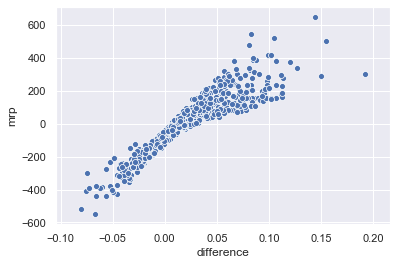

In [109]:
sns.scatterplot(mrp_17['difference'],results['mrp'])

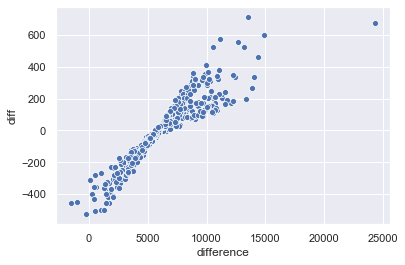

In [110]:
sns.scatterplot(diff_17.loc[constits_id]['difference'],results['diff'])

5.7414096188491195 Brigg and Goole
4.711697773584217 North Shropshire
4.604599441510534 Newark
4.335348611819366 Sherwood
4.224756741650159 Bassetlaw


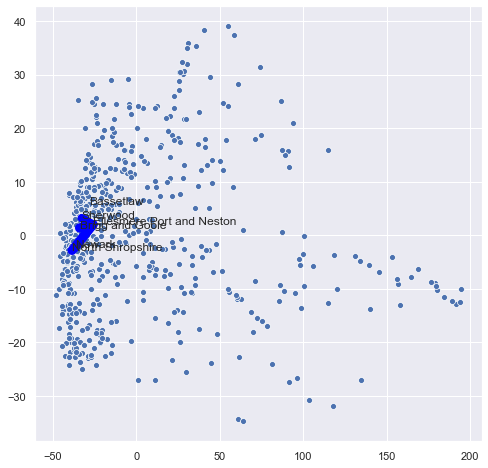

In [113]:
centre = 'Ellesmere Port and Neston'

significance_matrix = calc_significance_matrix(demographic_data, mrp_17.loc[constits_id]['difference'])
centre_i = constits_name_to_index[centre]
contributions = significance_matrix[centre_i]

# coi = constits of interest
coi   = [onsid_from_name(centre,ge17)]
linexs = []
lineys = []
values = []

N = 5
for i in np.flip(np.argsort(np.abs(contributions))[-N:]):
    onsid = demographic_data.index[i]
    coi += [onsid]
    values += [contributions[i]]
    print(contributions[i],name_from_onsid(onsid,ge17))

from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, MDS, TSNE
embedding = Isomap(n_components=2)


X = demographic_data#[mask]
X_transformed = embedding.fit_transform(X)
x = pd.Series(X_transformed[:,0])
y = pd.Series(X_transformed[:,1])

for c in coi:
    linexs += [ [x[centre_i],x[constits_onsid_to_index[c]] ] ]
    lineys += [ [y[centre_i],y[constits_onsid_to_index[c]] ] ]
    
plt.figure(figsize=(8,8))
ax = sns.scatterplot(x=x,y=y)
#values = preprocessing.scale(values)
for linex,liney,value in zip(linexs,lineys,values):
    plt.plot(linex,liney,linewidth=value*2, color='blue')

val = pd.Series([name_from_onsid(i,ge17) for i in X.index])
a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    
for c in coi:
    ax.text(x[constits_onsid_to_index[c]], y[constits_onsid_to_index[c]], name_from_onsid(c,ge17))
    #ax.text(point['x']+.001, point['y'], str(point['val']))

In [114]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=2)

## Cluster

In [115]:
from sklearn import cluster, covariance, manifold
from sklearn.cluster import AffinityPropagation

from sklearn import preprocessing
X = demographic_data
X_scaled = preprocessing.scale(X)

clustering = AffinityPropagation(verbose=True).fit(X)

Converged after 39 iterations.


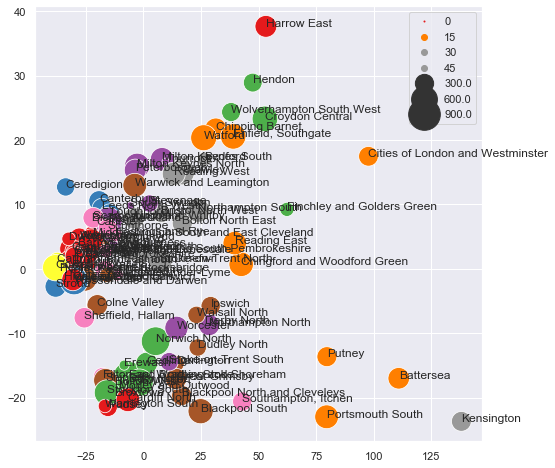

In [116]:
X = demographic_data.loc[marginals]
sizes = results['mrp'].loc[marginals]
sizes = np.array(sizes) - min(sizes)
hues = sizes
hues = list(pd.Series(clustering.labels_,index=results.index)[marginals])

#X = demographic_data
#sizes = results['mrp']

from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, MDS, TSNE

#embedding = LocallyLinearEmbedding(n_components=2)
embedding = Isomap(n_components=2)
#embedding = SpectralEmbedding(n_components=2)
#embedding = MDS(n_components=2)

X_transformed = embedding.fit_transform(X)
x = pd.Series(X_transformed[:,0])
y = pd.Series(X_transformed[:,1])
val = pd.Series([name_from_onsid(i,ge17) for i in X.index])
val.index=range(len(X_transformed))

plt.figure(figsize=(8,8))
ax = sns.scatterplot(x=x,y=y,
                     size=sizes, sizes=(1, 1000),
                     hue=hues, palette='Set1')
a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
for i, point in a.iterrows():
    ax.text(point['x']+.001, point['y'], str(point['val']))


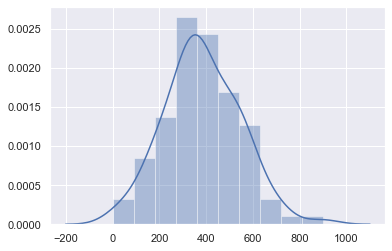

In [117]:
sns.distplot(sizes)